In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#libraries
import cv2
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Lambda
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import EfficientNetB2

In [ ]:
#Load data
train_data_dir=pathlib.Path('/content/drive/MyDrive/ACV/ACV - Project/Dataset_Emotion_Recognition/data/train')
test_data_dir=pathlib.Path('/content/drive/MyDrive/ACV/ACV - Project/Dataset_Emotion_Recognition/data/test')
train_img_count=len(list(train_data_dir.glob('*/*.jpg')))
test_img_count=len(list(test_data_dir.glob('*/*.jpg')))
print(train_img_count,test_img_count)


28830 7066


In [ ]:
img_width,img_height=48,48
batch_size=100

In [ ]:
#data augmentation
train_data_augmentation=keras.Sequential([layers.Resizing(img_width,img_height),
                                    layers.RandomTranslation(height_factor=0.02, width_factor=0.02),
                                    layers.RandomFlip("horizontal"),
                                    layers.RandomRotation(factor=0.02),
                                    #layers.Rescaling(1.0/255)
                                    ])
test_data_augmentation=keras.Sequential([layers.Resizing(48,48)])

In [ ]:
#Load data using Keras utility
train_ds=tf.keras.utils.image_dataset_from_directory(train_data_dir,validation_split=0.2,subset='training',seed=123,image_size=(img_width,img_height),batch_size=batch_size)
val_ds=tf.keras.utils.image_dataset_from_directory(train_data_dir,validation_split=0.2,subset='validation',seed=123,image_size=(img_width,img_height),batch_size=batch_size)
test_ds=tf.keras.utils.image_dataset_from_directory(test_data_dir,seed=123,image_size=(img_width,img_height),batch_size=batch_size)






Found 28830 files belonging to 7 classes.
Using 23064 files for training.
Found 28830 files belonging to 7 classes.
Using 5766 files for validation.
Found 7066 files belonging to 7 classes.


In [25]:
aug_train_ds=train_ds.map(lambda x,y:(train_data_augmentation(x,training=True),y))
aug_val_ds=val_ds.map(lambda x,y:(train_data_augmentation(x,training=True),y))
aug_test_ds=test_ds.map(lambda x,y:(test_data_augmentation(x,training=False),y))
for imgs,labels in aug_train_ds.take(1):
  print(labels.shape)


(100,)


['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


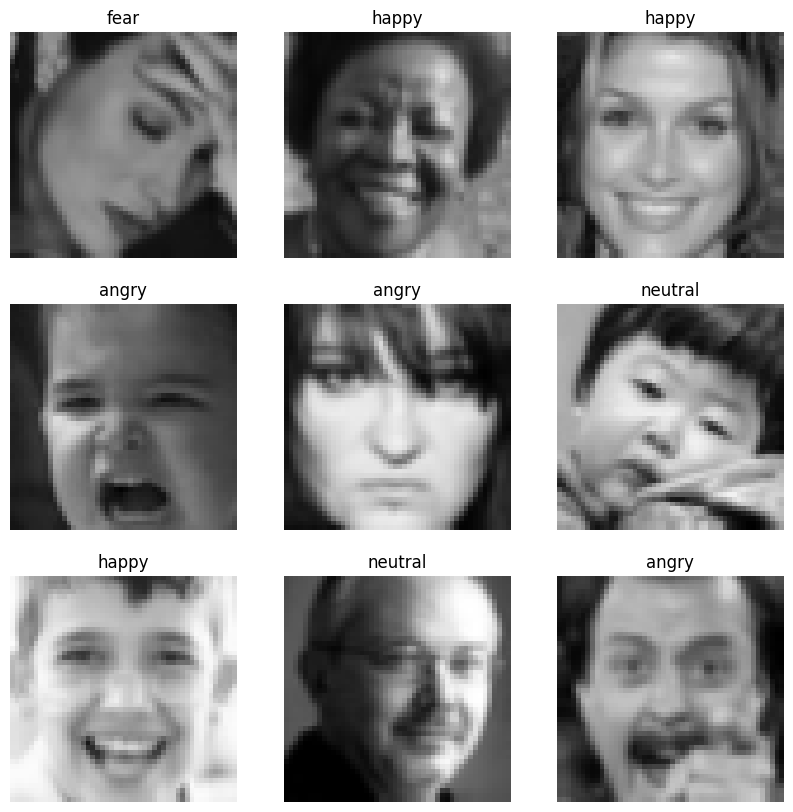

In [ ]:
class_names=train_ds.class_names
print(class_names)
num_classes=len(class_names)

#Plot sample images for all the classes
plt.figure(figsize=(10,10))
for images,labels in aug_train_ds.take(1):
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:

def preprocess_one_hot(x,y):
  return x,tf.one_hot(tf.cast(y, tf.int32),num_classes)

In [26]:
#one hot encoding of the output

aug_train_ds_enc= aug_train_ds.map(lambda x,y : preprocess_one_hot(x,y))
aug_val_ds_enc = aug_val_ds.map(lambda x,y : preprocess_one_hot(x,y))
aug_test_ds_enc = aug_test_ds.map(lambda x,y : preprocess_one_hot(x,y))
for imgs,labels in aug_train_ds_enc.take(1):
  print(labels.shape)

(100, 7)


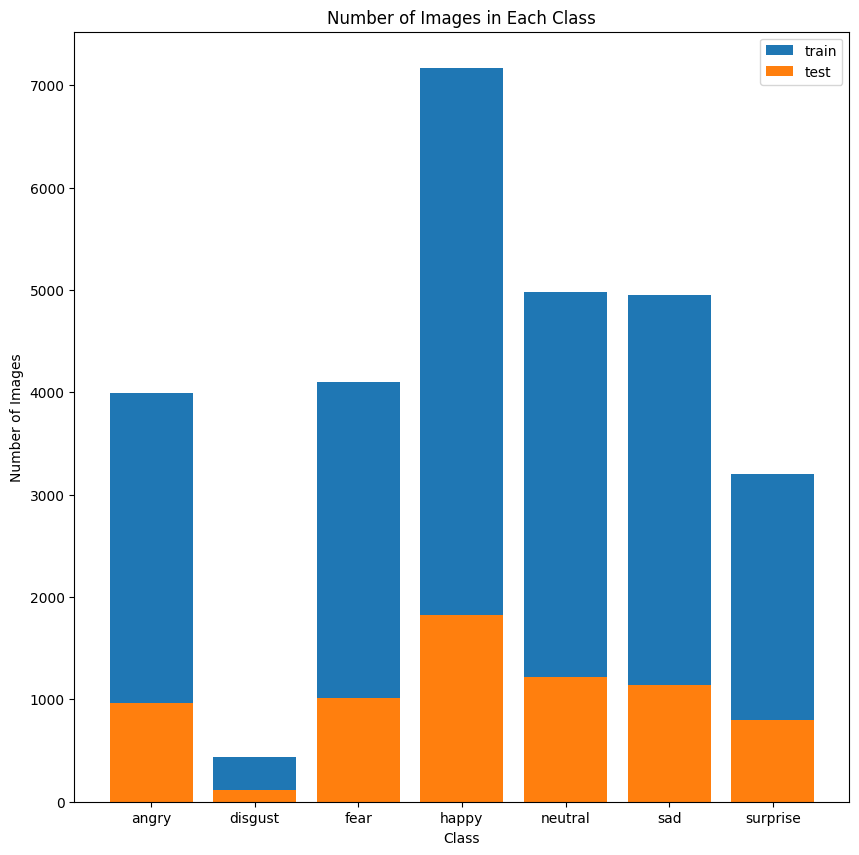

In [ ]:
#Plot the bar graph for the number of images in each class for both training and testing data

train_counts=[]
test_counts=[]
for name in class_names:
  train_count=len(list(train_data_dir.glob(name+'/*')))
  test_count=len(list(test_data_dir.glob(name+'/*')))
  train_counts.append(train_count)
  test_counts.append(test_count)

plt.figure(figsize=(10,10))
plt.bar(class_names,train_counts,label='train')
plt.bar(class_names,test_counts,label='test')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.legend()
plt.show()

In [ ]:
print("Num GPUS Available: ",len(tf.config.list_physical_devices('GPU')))
gpus=tf.config.list_logical_devices('GPU')
strategy=tf.distribute.MirroredStrategy(gpus)

Num GPUS Available:  1


In [ ]:
# #Build Model
# with strategy.scope():
#   model=Sequential([
#       layers.Rescaling(1./255, input_shape=(48, 48, 3)),
#       layers.Conv2D(16,3,padding='same',activation='relu'),
#       layers.MaxPooling2D(),
#       layers.BatchNormalization(),
#       layers.Conv2D(32,3,padding='same',activation='relu'),
#       layers.MaxPooling2D(),
#       layers.BatchNormalization(),
#       layers.Conv2D(64,3,padding='same',activation='relu'),
#       layers.MaxPooling2D(),
#       layers.BatchNormalization(),
#       layers.Dropout(0.2),
#       layers.Flatten(),
#       layers.Dense(128,activation='relu'),
#       layers.Dense(num_classes,name='outputs')
#   ])

# Customised CNN

In [ ]:
# with strategy.scope():
#   model=Sequential([
#       layers.Rescaling(1./255, input_shape=(48, 48, 3)),
#       layers.Conv2D(16,3,padding='same'),
#       layers.LeakyReLU(alpha=0.1),
#       layers.MaxPooling2D(),
#       layers.BatchNormalization(),
#       layers.Conv2D(32,3,padding='same'),
#       layers.LeakyReLU(alpha=0.1),
#       layers.MaxPooling2D(),
#       layers.BatchNormalization(),
#       layers.Conv2D(64,3,padding='same'),
#       layers.LeakyReLU(alpha=0.1),
#       layers.MaxPooling2D(),
#       layers.BatchNormalization(),
#       layers.Conv2D(128,3,padding='same'),
#       layers.LeakyReLU(alpha=0.1),
#       layers.MaxPooling2D(),
#       layers.BatchNormalization(),
#       layers.Dropout(0.2),
#       layers.Flatten(),
#       layers.Dense(256),
#       layers.LeakyReLU(alpha=0.1),
#       layers.Dense(num_classes,name='outputs')
#   ])

#Transfer learning

In [43]:
def build_model(num_classes):
  inputs = layers.Input(shape=(img_height, img_width, 3))
  x = train_data_augmentation(inputs)
  model = EfficientNetB2(include_top=False, input_tensor=x, weights="imagenet")

  # Freeze the pretrained weights
  model.trainable = False

  # Rebuild top
  x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
  x = layers.BatchNormalization()(x)

  top_dropout_rate = 0.2
  x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
  #x = layers.Flatten()(x)
  outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

  # Compile
  model = tf.keras.Model(inputs, outputs, name="EfficientNet")
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
  model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
   )
  return model

In [ ]:
#early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)


In [ ]:
#model.compile(optimizer='adam',loss=tf.keras.losses.categorical_crossentropy,metrics=['accuracy'])

In [44]:
with strategy.scope():
  epochs=10
  #history=model.fit(aug_train_ds,validation_data=aug_val_ds,epochs=epochs,callbacks=[early_stopping])
  model = build_model(num_classes=num_classes)
  history=model.fit(aug_train_ds_enc,validation_data=aug_val_ds_enc,epochs=epochs)


Epoch 1/10
231/231 [==============================] - 49s 157ms/step - loss: 2.3356 - accuracy: 0.2849 - val_loss: 1.7459 - val_accuracy: 0.3117
Epoch 2/10
231/231 [==============================] - 39s 166ms/step - loss: 1.8416 - accuracy: 0.3222 - val_loss: 1.6309 - val_accuracy: 0.3685
Epoch 3/10
231/231 [==============================] - 36s 155ms/step - loss: 1.6922 - accuracy: 0.3406 - val_loss: 1.6121 - val_accuracy: 0.3796
Epoch 4/10
231/231 [==============================] - 35s 149ms/step - loss: 1.6622 - accuracy: 0.3480 - val_loss: 1.6024 - val_accuracy: 0.3687
Epoch 5/10
231/231 [==============================] - 40s 172ms/step - loss: 1.6564 - accuracy: 0.3460 - val_loss: 1.6109 - val_accuracy: 0.3616
Epoch 6/10
231/231 [==============================] - 39s 166ms/step - loss: 1.6600 - accuracy: 0.3456 - val_loss: 1.6139 - val_accuracy: 0.3718
Epoch 7/10
231/231 [==============================] - 35s 148ms/step - loss: 1.6557 - accuracy: 0.3438 - val_loss: 1.6002 - val_ac

In [37]:
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 48, 48, 3)    0           ['input_4[0][0]']                
                                                                                                  
 rescaling_6 (Rescaling)        (None, 48, 48, 3)    0           ['sequential[3][0]']             
                                                                                                  
 normalization_3 (Normalization  (None, 48, 48, 3)   7           ['rescaling_6[0][0]']            
 )                                                                                     

In [39]:
tf.saved_model.save(model, 'cnn-emotion3_saved_model')

Text(0.5, 1.0, 'Training and validation accuracy')

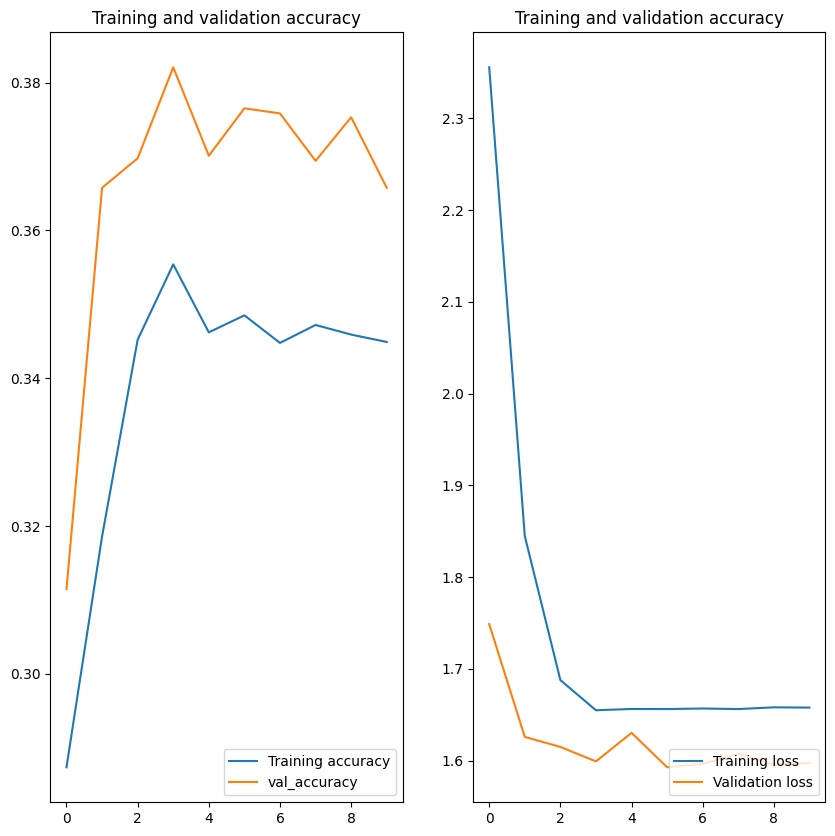

In [32]:
#Plot the training and validation accuracy, and the loss
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss = history.history['loss']
val_loss=history.history['val_loss']
epochs_range=range(epochs)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training accuracy')
plt.plot(epochs_range,val_acc,label='val_accuracy')
plt.legend(loc='lower right')
plt.title("Training and validation accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Training loss')
plt.plot(epochs_range,val_loss,label='Validation loss')
plt.legend(loc='lower right')
plt.title("Training and validation accuracy")

(100, 48, 48, 3) (100, 7)
1/1 [==============================] - 2s 2s/step
This image #0  most likely belongs to happy with a 40.42 percent confidence.
(100, 48, 48, 3) (100, 7)
1/1 [==============================] - 0s 91ms/step
This image #1  most likely belongs to happy with a 39.46 percent confidence.
(100, 48, 48, 3) (100, 7)
1/1 [==============================] - 0s 87ms/step
This image #2  most likely belongs to happy with a 45.32 percent confidence.
(100, 48, 48, 3) (100, 7)
1/1 [==============================] - 0s 88ms/step
This image #3  most likely belongs to angry with a 35.48 percent confidence.
(100, 48, 48, 3) (100, 7)
1/1 [==============================] - 0s 91ms/step
This image #4  most likely belongs to fear with a 31.78 percent confidence.
(100, 48, 48, 3) (100, 7)
1/1 [==============================] - 0s 86ms/step
This image #5  most likely belongs to happy with a 46.64 percent confidence.
(100, 48, 48, 3) (100, 7)
1/1 [==============================] - 0s 85ms/

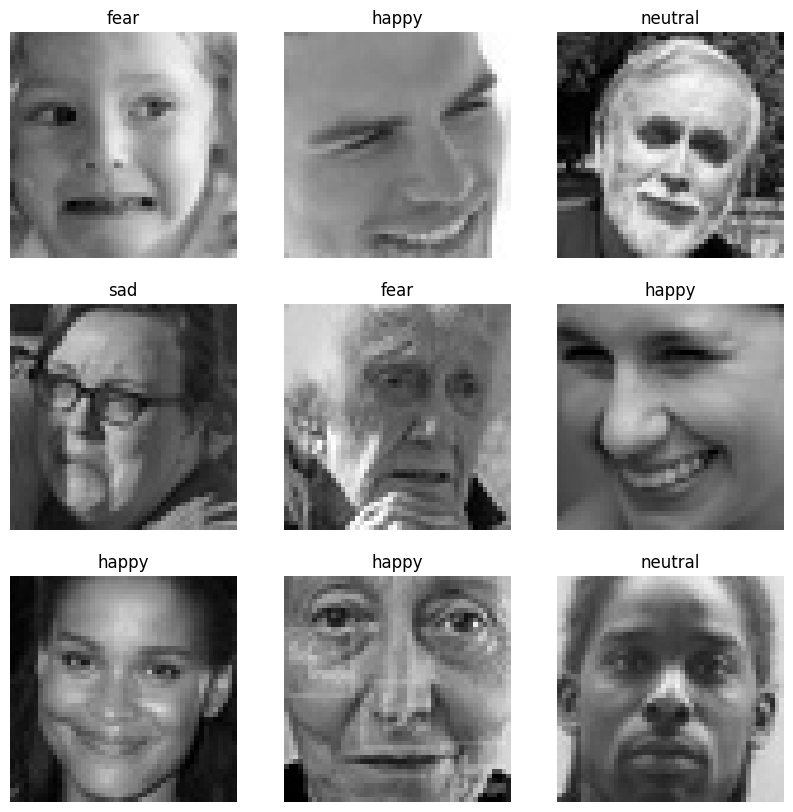

In [45]:
# Predictions and ground truth labels
plt.figure(figsize=(10, 10))
test_labels = []
predictions = []
scores = []

for images, labels in aug_test_ds_enc.take(1):
    for i in range(9):
        print(images.shape,labels.shape)
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
        img_arr = tf.expand_dims(images[i].numpy().astype('uint8'), 0)
        test_labels.append(np.argmax(labels[i]))

        p = model.predict(img_arr)
        #print(p[i])
        scores.append(p)
        predictions.extend(np.argmax(p, axis=1)) #index of highest predicted value

        print("This image #{}  most likely belongs to {} with a {:.2f} percent confidence."
              .format(i, class_names[np.argmax(p)], 100 * np.max(p)))
print(len(test_labels))
#len(predictions)

In [48]:
from sklearn.metrics import classification_report
predictions = np.array(predictions)
test_labels= np.array(test_labels)
print(len(predictions),len(test_labels))
#scores = np.concatenate(scores, axis=0)  # Concatenate scores from all images
class_names=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
# Calculate classification report
report = classification_report(test_labels, predictions, zero_division=0)
print(report)

9 9
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           2       1.00      0.50      0.67         2
           3       0.67      1.00      0.80         4
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         0

    accuracy                           0.56         9
   macro avg       0.28      0.25      0.24         9
weighted avg       0.52      0.56      0.50         9

